In [1]:
!pip install netCDF4
!pip install xgboost
import netCDF4
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import re

import xgboost as xgb
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Define the base directory
sat_dir = os.path.expanduser('~/sea-level-seekers/iharp_training_dataset/Copernicus_ENA_Satelite_Maps_Training_Data')
sat_names = os.listdir(sat_dir)
flood_dir = os.path.expanduser('~/sea-level-seekers/iharp_training_dataset/Flooding_Data')
flood_names = os.listdir(flood_dir)

In [3]:
# Get a list of all file names with their full paths
try:
    sat_names = [os.path.join(sat_dir, f) for f in os.listdir(sat_dir)]
    flood_names = [os.path.join(flood_dir, f) for f in os.listdir(flood_dir) if f.endswith('.csv')]
except FileNotFoundError:
    print(f"Directory not found")


In [4]:
dataset = netCDF4.Dataset(sat_names[0], mode="r")

In [5]:
print(dataset)

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    cdm_data_type: Grid
    comment: Sea Surface Height measured by Altimetry and derived variables
    contact: http://climate.copernicus.eu/c3s-user-service-desk
    creator_email: http://climate.copernicus.eu/c3s-user-service-desk
    creator_name: Copernicus Climate Change Service (C3S)
    creator_url: http://climate.copernicus.eu
    date_created: 2021-07-09T08:53:57Z
    date_issued: 2021-07-09T08:53:57Z
    date_modified: 2021-07-09T08:53:57Z
    geospatial_lat_max: 89.875
    geospatial_lat_min: -89.875
    geospatial_lat_resolution: 0.25
    geospatial_lat_units: degrees_north
    geospatial_lon_max: 179.875
    geospatial_lon_min: -179.875
    geospatial_lon_resolution: 0.25
    geospatial_lon_units: degrees_east
    geospatial_vertical_max: 0.0
    geospatial_vertical_min: 0.0
    geospatial_vertical_positive: down
   

In [6]:
sla = dataset.variables["sla"][0]

# Extract the latitude and longitude
latitude = dataset.variables["latitude"][:]
longitude = dataset.variables["longitude"][:]

In [7]:
print(np.shape(dataset.variables["latitude"][:]))

(100,)


In [8]:
def date_extractor(filename):
    file_name = filename
    
    # Regular expression to extract the date
    match = re.search(r'dt_ena_(\d+)_vDT', file_name)
    date_str = match.group(1)  # '19930101'
    
    # Format the date as 'YYYY-MM-DD'
    formatted_date = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
    
    return formatted_date

In [9]:
dataset.close()

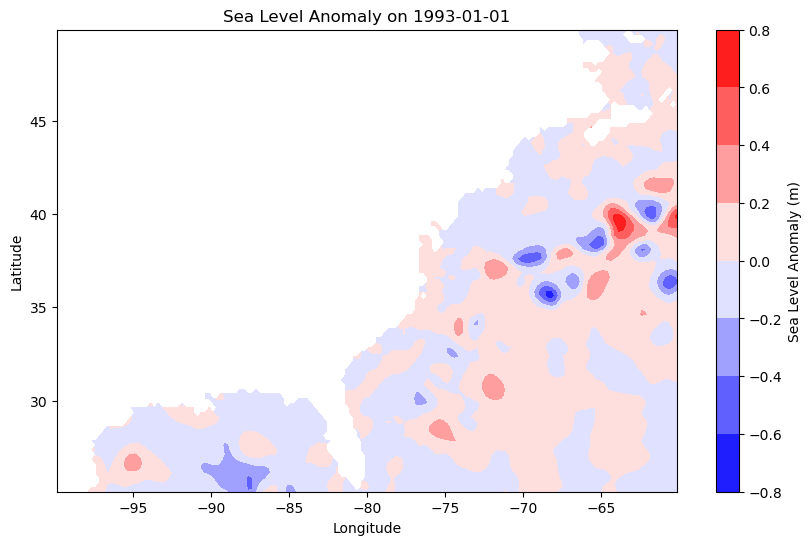

In [10]:
# Create a meshgrid for plotting
lon, lat = np.meshgrid(longitude, latitude)

# Plot the 'sla' variable
plt.figure(figsize=(10, 6))
plt.contourf(lon, lat, sla, cmap="bwr")
plt.colorbar(label="Sea Level Anomaly (m)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Sea Level Anomaly on " + date_extractor(sat_names[0]))
plt.show()

In [11]:
!pip install tqdm

In [25]:
import numpy as np
import netCDF4
from tqdm import tqdm  # Import tqdm for the progress bar

# Assuming sat_names is a list of file paths and the number of files is known
num_files = len(sat_names)
sla_shape = (4, 100, 160)  # Shape of the SLA data per file
sla_data = np.empty((num_files, *sla_shape))  # Preallocate memory for SLA data
sla_dates = []  # Initialize a list for dates

# Use tqdm to wrap the loop for a progress bar
for i, file_path in enumerate(tqdm(sat_names, desc="Processing SLA data")):
    with netCDF4.Dataset(file_path, mode="r") as dataset:
        time_array = np.array([100, 160])
        sla_data[i][0] = time_array.fill(dataset.variables["time"][0])
        sla_data[i][1] = dataset.variables["sla"][0]  # Read and store the first SLA data slice
        sla_data[i][2] = dataset.variables["ugosa"][0]
        sla_data[i][3] = dataset.variables["vgosa"][0]
        sla_dates.append(date_extractor(file_path))  # Extract and store the date

print(sla_data.shape)

Processing SLA data: 100%|██████████| 7302/7302 [06:09<00:00, 19.75it/s]

(7302, 4, 100, 160)


In [26]:
np.save('X.npy', sla_data)

OSError: Not enough free space to write 3738624000 bytes

In [20]:
flood_data = []
flood_dates = []

for f in flood_names:
    df = pd.read_csv(f)
    flood_data.append(df['anomaly'][:1000].values)
    flood_dates.append(df['t'][:1000].values)

flood_data = np.array(flood_data).T
print(np.shape(flood_data))

(1000, 12)


In [21]:
select_feature_names = ['time', 'sla', 'ugosa', 'vgosa']

In [22]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier

In [23]:
X = np.load('X.npy')
y = flood_data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [24]:
scale_pos_weight = []
for i in range(12):
    n_bkg = np.sum(y_train[:, i] == 0)
    n_sig = np.sum(y_train[:, i] == 1)
    scale_pos_weight.append(n_bkg/n_sig)

print(scale_pos_weight)

[20.62162162162162, 199.0, 159.0, 46.05882352941177, 199.0, inf, 799.0, 56.142857142857146, 60.53846153846154, 18.51219512195122, 39.0, 79.0]


/tmp/ipykernel_650/2273377537.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  scale_pos_weight.append(n_bkg/n_sig)


In [32]:
X = np.load('X.npy')

In [33]:
print(X.shape)

(7302, 16000)


In [25]:
# Create the base XGBClassifier with the binary:logistic objective
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        eval_metric='logloss', 
                        seed=42, 
                        early_stopping_rounds=10)

# Wrap the XGBClassifier in MultiOutputClassifier to handle multi-output problem
multi_output_xgb = MultiOutputClassifier(xgb_clf)

# Fit the model first
multi_output_xgb.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)

# Now, modify scale_pos_weight for each classifier in estimators_
for i, clf in enumerate(multi_output_xgb.estimators_):
    clf.set_params(scale_pos_weight=scale_pos_weight[i])  # Set scale_pos_weight for each classifier

# Make predictions
y_pred = multi_output_xgb.predict(X_test)

XGBoostError: [19:29:40] /workspace/src/objective/regression_obj.cu:50: Check failed: info.labels.Size() == preds.Size() (5841 vs. 70092) : Invalid shape of labels.
Stack trace:
  [bt] (0) /opt/conda/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x22dcbc) [0x7f64a462dcbc]
  [bt] (1) /opt/conda/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xc30292) [0x7f64a5030292]
  [bt] (2) /opt/conda/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0xc76a3f) [0x7f64a5076a3f]
  [bt] (3) /opt/conda/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(+0x5cb173) [0x7f64a49cb173]
  [bt] (4) /opt/conda/lib/python3.11/site-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x6f) [0x7f64a453752f]
  [bt] (5) /opt/conda/lib/python3.11/lib-dynload/../../libffi.so.8(+0x6a4a) [0x7f650e8d3a4a]
  [bt] (6) /opt/conda/lib/python3.11/lib-dynload/../../libffi.so.8(+0x5fea) [0x7f650e8d2fea]
  [bt] (7) /opt/conda/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x12545) [0x7f650e8eb545]
  [bt] (8) /opt/conda/lib/python3.11/lib-dynload/_ctypes.cpython-311-x86_64-linux-gnu.so(+0x887a) [0x7f650e8e187a]



In [ ]:
# Create the base model (XGBClassifier with binary:logistic objective)
xgb_clf = XGBClassifier(objective='binary:logistic', 
                        eval_metric='logloss', 
                        seed=42, 
                        early_stopping_rounds=10)

# Wrap the XGBClassifier in MultiOutputClassifier to handle multi-output problem
multi_output_xgb = MultiOutputClassifier(xgb_clf)

# Train the model on the multi-output data
multi_output_xgb.fit(X_train, y_train)

# Make predictions
y_pred = multi_output_xgb.predict(X_test)


In [16]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

# Flatten the SLA grid for each day
X = np.load('X.npy').reshape(7302, -1)  # Shape (7302, 16000)
y = flood_data  # Shape (7302, 12)

In [17]:
print(X.shape)

(7302, 16000)


In [64]:
# Split the data chronologically
train_size = int(0.8 * X.shape[0])  # 80% for training, 20% for testing
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize a list to store trained models
models = []

# Train an XGBoost model for each city
for city_idx in range(y.shape[1]-10):
    # Define the target variable for this city
    y_train_city = y_train[:, city_idx]
    y_test_city = y_test[:, city_idx]

    # Balance the classes (scale_pos_weight)
    n_background = np.sum(y_train_city == 0)
    n_signal = np.sum(y_train_city == 1)
    scale_pos_weight = n_background / n_signal
    print(scale_pos_weight)

    # Convert data to DMatrix format for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train_city)
    dtest = xgb.DMatrix(X_test, label=y_test_city)

    # Define parameters for XGBoost
    params = {
        'max_depth': 4,
        'eta': 0.01,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss', 
        'scale_pos_weight': scale_pos_weight
    }
    evals = [(dtest, 'eval'), (dtrain, 'train')]

    # Train the model for the current city
    bst = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=50,
        evals=evals,
        early_stopping_rounds=10
    )

    # Store the trained model
    models.append(bst)

    # Optionally, print the model performance for the city
    print(f"Trained model for city {city_idx + 1}.")

17.661341853035143
[0]	eval-logloss:0.69024	train-logloss:0.68951
[1]	eval-logloss:0.68721	train-logloss:0.68594
[2]	eval-logloss:0.68453	train-logloss:0.68239
[3]	eval-logloss:0.68132	train-logloss:0.67801
[4]	eval-logloss:0.67864	train-logloss:0.67461
[5]	eval-logloss:0.67535	train-logloss:0.67027
[6]	eval-logloss:0.67259	train-logloss:0.66606
[7]	eval-logloss:0.67016	train-logloss:0.66277
[8]	eval-logloss:0.66821	train-logloss:0.65878
[9]	eval-logloss:0.66566	train-logloss:0.65477
[10]	eval-logloss:0.66401	train-logloss:0.65162
[11]	eval-logloss:0.66188	train-logloss:0.64784
[12]	eval-logloss:0.65974	train-logloss:0.64390
[13]	eval-logloss:0.65770	train-logloss:0.64088
[14]	eval-logloss:0.65537	train-logloss:0.63717
[15]	eval-logloss:0.65363	train-logloss:0.63351
[16]	eval-logloss:0.65230	train-logloss:0.63055
[17]	eval-logloss:0.65008	train-logloss:0.62699
[18]	eval-logloss:0.64906	train-logloss:0.62421
[19]	eval-logloss:0.64741	train-logloss:0.62086
[20]	eval-logloss:0.64491	train

NameError: name 'classification_report' is not defined

In [65]:
from sklearn.metrics import classification_report

# Evaluate the models for each city
for city_idx, bst in enumerate(models):
    y_pred = bst.predict(dtest)
    y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class labels
    print(f"Classification report for city {city_idx + 1}:")
    print(classification_report(y_test[:, city_idx], y_pred))


Classification report for city 1:
              precision    recall  f1-score   support

           0       0.94      0.77      0.85      1336
           1       0.17      0.52      0.26       125

    accuracy                           0.75      1461
   macro avg       0.56      0.64      0.55      1461
weighted avg       0.88      0.75      0.80      1461

Classification report for city 2:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1440
           1       0.00      0.00      0.00        21

    accuracy                           0.98      1461
   macro avg       0.49      0.50      0.49      1461
weighted avg       0.97      0.98      0.97      1461

